In [1]:
!pip install keybert summa gensim yake spacy seaborn

In [2]:
import spacy
!python -m spacy download en_core_web_lg
nlp = spacy.load("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 2.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')


In [3]:
import pandas as pd
import numpy as np
import re
import os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from keybert import KeyBERT
from summa import keywords

from gensim import corpora
from gensim.models import LdaModel
from yake import KeywordExtractor
import string

nltk.download('punkt')
nltk.download('stopwords')

import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-08-08 04:59:44.468769: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Text Test i.e. the source of truth

In [77]:
#section_test = wiki_content_df.sample() # pull the content value as a string and save as text_test
#text_test = section_test['content'].values[0]

In [4]:
text_test = """Spatial inference, or estimation, of a quantity Z : : R n → → R {{\\displaystyle Z\\colon \\mathbb {{R}} ^{{n}}\\to \\mathbb {{R}} }} , at an unobserved location x 0 {{\\displaystyle x_{{0}}}} , is calculated from a linear combination of the observed values z i = Z ( x i ) {{\\displaystyle z_{{i}}=Z(x_{{i}})}} and weights w i ( x 0 ) , i = 1 , … … , N {{\\displaystyle w_{{i}}(x_{{0}}),\\;i=1,\\ldots ,N}} : The weights w i {{\\displaystyle w_{{i}}}} are intended to summarize two extremely important procedures in a spatial inference process: reflect the structural "proximity" of samples to the estimation location x 0 {{\\displaystyle x_{{0}}}} ; at the same time, they should have a desegregation effect, in order to avoid bias caused by eventual sample clusters. When calculating the weights w i {{\\displaystyle w_{{i}}}} , there are two objectives in the geostatistical formalism: unbias and minimal variance of estimation. If the cloud of real values Z ( x 0 ) {{\\displaystyle Z(x_{{0}})}} is plotted against the estimated values Z ^ ^ ( x 0 ) {{\\displaystyle {{\\hat {{Z}}}}(x_{{0}})}} , the criterion for global unbias, intrinsic stationarity or [wide sense stationarity](https://en.wikipedia.org/wiki/Stationary_process) of the field, implies that the mean of the estimations must be equal to mean of the real values. The second criterion says that the mean of the squared deviations ( Z ^ ^ ( x ) − − Z ( x ) ) {{\\displaystyle {{\\big (}}{{\\hat {{Z}}}}(x)-Z(x){{\\big }}}} must be minimal, which means that when the cloud of estimated values versus the cloud real values is more disperse, the estimator is more imprecise."""

# Plagiarised Text Keywords 
i.e. common keywords captured from multiple summarisation, rewriting, and paraphrasing methods of the text_test data

The following list ("prime_keywords") is created using LLM Agent that are trained to generate multiple paraphrases, rewrites, and summaries from a given text. 
The Paraphrase LLM Agent generates three examples, of which a unique list of n-grams words are generated representing the intersection of words existing in all three lists ("paraphrase_keywords"). 
This process is repeated for the Rewriting LLM Agent ("rewrite_keywords") as well as the Summary LLM Agent ("summary_keywords") until each agent has their own unique list. 
A final list, consisting of the intersection of all three unique lists is created - representing the words that are the most 'irreplaceable' in the text and therefore most important to match. 


In [5]:
prime_keywords = [
    'location', 'linear', 'estimation', 'spatial', 'quantity', 
    'combination', 'proximity', 'values', 'unobserved', 'z', 
    'mean', 'inference', 'weights', 'observed'
]

In [38]:
paraphrase_keywords = [
    'linear',
    'estimation',
    'spatial',
    'deviations',
    'geostatistical',
    'variance',
    'combination',
    'samples',
    'squared',
    'location',
    'proximity',
    'z',
    'weights',
    'aims',
    'involves',
    'real',
    'values',
    'unobserved',
    'mean',
    'observed'
]

In [39]:
rewrite_keywords = [
    'estimation',
    'spatial',
    'also',
    'deviations',
    'geostatistical',
    'ensuring',
    'unbiased',
    'variance',
    'quantity',
    'global',
    'realm',
    'samples',
    'process',
    'location',
    'proximity',
    'z',
    'weights',
    'involves',
    'real',
    'values',
    'estimator',
    'minimal',
    'observed'
]

In [40]:
summary_keywords = [
    'linear',
    'estimation',
    'spatial',
    'deviations',
    'unbiased',
    'quantity',
    'combination',
    'global',
    'using',
    'unbias',
    'equal',
    'squared',
    'location',
    'proximity',
    'z',
    'weights',
    'involves',
    'real',
    'estimations',
    'values',
    'unobserved',
    'estimating',
    'x0',
    'inference',
    'mean',
    'minimal',
    'observed'
]

In [19]:
max_length = len(prime_keywords)

# Data (Text) preparation

In [30]:
def preprocess_text(text):
    """
    Preprocess the input text by converting to lowercase, removing punctuation,
    tokenizing, and removing stopwords.

    Args:
    text (str): The input text to be preprocessed.

    Returns:
    list: A list of preprocessed tokens.
    """
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# NLP Methods

Machine learning techniques to evaluate against our Plagiarism Agent:

TF-IDF (Term Frequency-Inverse Document Frequency):
This technique would likely highlight words that are frequent in this text but less common in general usage.

KeyBERT or similar keyword extraction models:
These models use BERT embeddings to identify keywords that are most representative of the document.

TextRank or LexRank:
Graph-based algorithms that could identify important words based on their relationships with other words in the text.

Named Entity Recognition (NER):
This would specifically highlight pronouns.

Latent Dirichlet Allocation (LDA) for topic modeling:
This technique could identify the main topics and associated key terms in the text.

YAKE! (Yet Another Keyword Extractor):
This unsupervised approach considers features like word position and frequency to extract keywords.

These techniques will be assessed to see how well they identify unigrams that the Plagiarism Agent was unable to substitute (no matter the approach), due to their frequency, uniqueness, or importance to the overall meaning of the text. 

## TF-IDF

In [17]:
def tf_idf(text):
    """
    Compute TF-IDF scores for words in the input text and return them sorted by importance.

    Args:
    text (str): The input text to analyze.

    Returns:
    list: A list of words sorted by their TF-IDF scores in descending order.
    """
    vectorizer = TfidfVectorizer(stop_words='english', max_features=max_length)
    tfidf_matrix = vectorizer.fit_transform([text])
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.toarray()[0]
    sorted_items = sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)
    return [item[0] for item in sorted_items]

## KeyBERT

In [21]:
def keybert_extraction(text):
    """
    Extract keywords from the input text using KeyBERT.

    Args:
    text (str): The input text to analyze.

    Returns:
    list: A list of keywords extracted from the text, limited to the top 'max_length' results.
    """
    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(text, keyphrase_ngram_range=(1, 1), stop_words='english', top_n=max_length)
    return [kw[0] for kw in keywords]

## Textrank

In [22]:
def textrank(text):
    """
    Extract keywords from the input text using TextRank algorithm.

    Args:
    text (str): The input text to analyze.

    Returns:
    list: A list of unique unigram keywords extracted from the text, 
          limited to the top 'max_length' results. Returns an empty list if an error occurs.
    """
    try:
        tr_keywords = keywords.keywords(text, words=max_length)
        if not tr_keywords:
            return []
        
        unigrams = []
        for phrase in tr_keywords.split('\n'):
            words = re.findall(r'\b\w+\b', phrase.lower())
            unigrams.extend(words)
        
        return list(dict.fromkeys(unigrams))
    except IndexError:
        return []
    except Exception as e:
        print(f"An error occurred in TextRank: {str(e)}")
        return []

## NER

In [23]:
def named_entity_recognition(text):
    """
    Perform Named Entity Recognition on the input text using spaCy.

    Args:
    text (str): The input text to analyze.

    Returns:
    list: A list of unique, lowercase named entities found in the text.
    """
    doc = nlp(text)
    return list(set([ent.text.lower() for ent in doc.ents]))

## LDA Topic Modelling

In [25]:
def lda_topic_modeling(text):
    """
    Perform LDA (Latent Dirichlet Allocation) topic modeling on the input text.

    Args:
    text (str): The input text to analyze.

    Returns:
    list: A list of words representing the most significant terms in the identified topic.
    """
    tokens = preprocess_text(text)
    dictionary = corpora.Dictionary([tokens])
    corpus = [dictionary.doc2bow(tokens)]
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=1, random_state=42)
    topics = lda_model.print_topics(num_words=max_length)
    words = topics[0][1].split('+')
    return [word.split('*')[1].strip().replace('"', '') for word in words]

## Yake Extraction

In [26]:
def yake_extraction(text):
    """
    Extract keywords from the input text using YAKE (Yet Another Keyword Extractor).

    Args:
    text (str): The input text to analyze.

    Returns:
    list: A list of keywords extracted from the text, limited to the top 'max_length' results.
    """
    kw_extractor = KeywordExtractor(lan="en", n=1, top=max_length)
    keywords = kw_extractor.extract_keywords(text)
    return [kw[0] for kw in keywords]

# Evaluation

## Keywords Evaluation

In [27]:
def evaluate_techniques(correct_list, technique_results):
    """
    Evaluate the performance of different keyword extraction techniques.

    Args:
    correct_list (list): A list of correct keywords.
    technique_results (dict): A dictionary where keys are technique names and values are lists of extracted keywords.

    Returns:
    dict: A dictionary containing evaluation results for each technique, including the number of correct and incorrect keywords found.
    """
    evaluation = {}
    for technique, results in technique_results.items():
        correct_found = len(set(results) & set(correct_list))
        incorrect_found = len(results) - correct_found
        evaluation[technique] = {
            'correct_found': correct_found,
            'incorrect_found': incorrect_found
        }
    return evaluation

In [34]:
def visualize_results(correct_list, technique_results):
    """
    Visualize the performance of different keyword extraction techniques using a heatmap.

    Args:
    correct_list (list): A list of correct keywords.
    technique_results (dict): A dictionary where keys are technique names and values are lists of extracted keywords.

    Returns:
    None: Displays a heatmap visualization.
    """
    techniques = list(technique_results.keys())
    words = correct_list
    
    matrix = np.zeros((len(techniques), len(words)))
    
    for i, technique in enumerate(techniques):
        for j, word in enumerate(words):
            if word in technique_results[technique]:
                matrix[i, j] = 1
    
    plt.figure(figsize=(15, 10))
    sns.heatmap(matrix, annot=True, cmap="YlGnBu", xticklabels=words, yticklabels=techniques)
    
    plt.title("Keywords Identified by Different Techniques")
    plt.xlabel("Correct Keywords")
    plt.ylabel("Techniques")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


### Complete Test: Evaluation (All)

Eval List:
['location', 'linear', 'estimation', 'spatial', 'quantity', 'combination', 'proximity', 'values', 'unobserved', 'z', 'mean', 'inference', 'weights', 'observed']
Results:

TF-IDF:
Extracted keywords: ['displaystyle', 'values', 'x_', 'cloud', 'estimation', 'mean', 'real', 'w_', 'weights', 'estimated', 'inference', 'location', 'minimal', 'stationarity']
Correct found: 6
Incorrect found: 8

KeyBERT:
Extracted keywords: ['desegregation', 'estimation', 'estimations', 'unobserved', 'unbias', 'inference', 'weights', 'bias', 'observed', 'estimator', 'spatial', 'intrinsic', 'samples', 'geostatistical']
Correct found: 6
Incorrect found: 8

TextRank:
Extracted keywords: ['z', 'z_', 'displaystyle', 'values', 'unbias', 'stationarity', 'criterion', 'important', 'samples', 'sample', 'bias', 'r', 'x_', 'process', 'inference', 'location', 'x']
Correct found: 4
Incorrect found: 13

NER:
Extracted keywords: ['1', 'second', '\\displaystyle w_{{i}}(x_{{0}}),\\;i=1,\\ldots', 'two']
Correct found: 

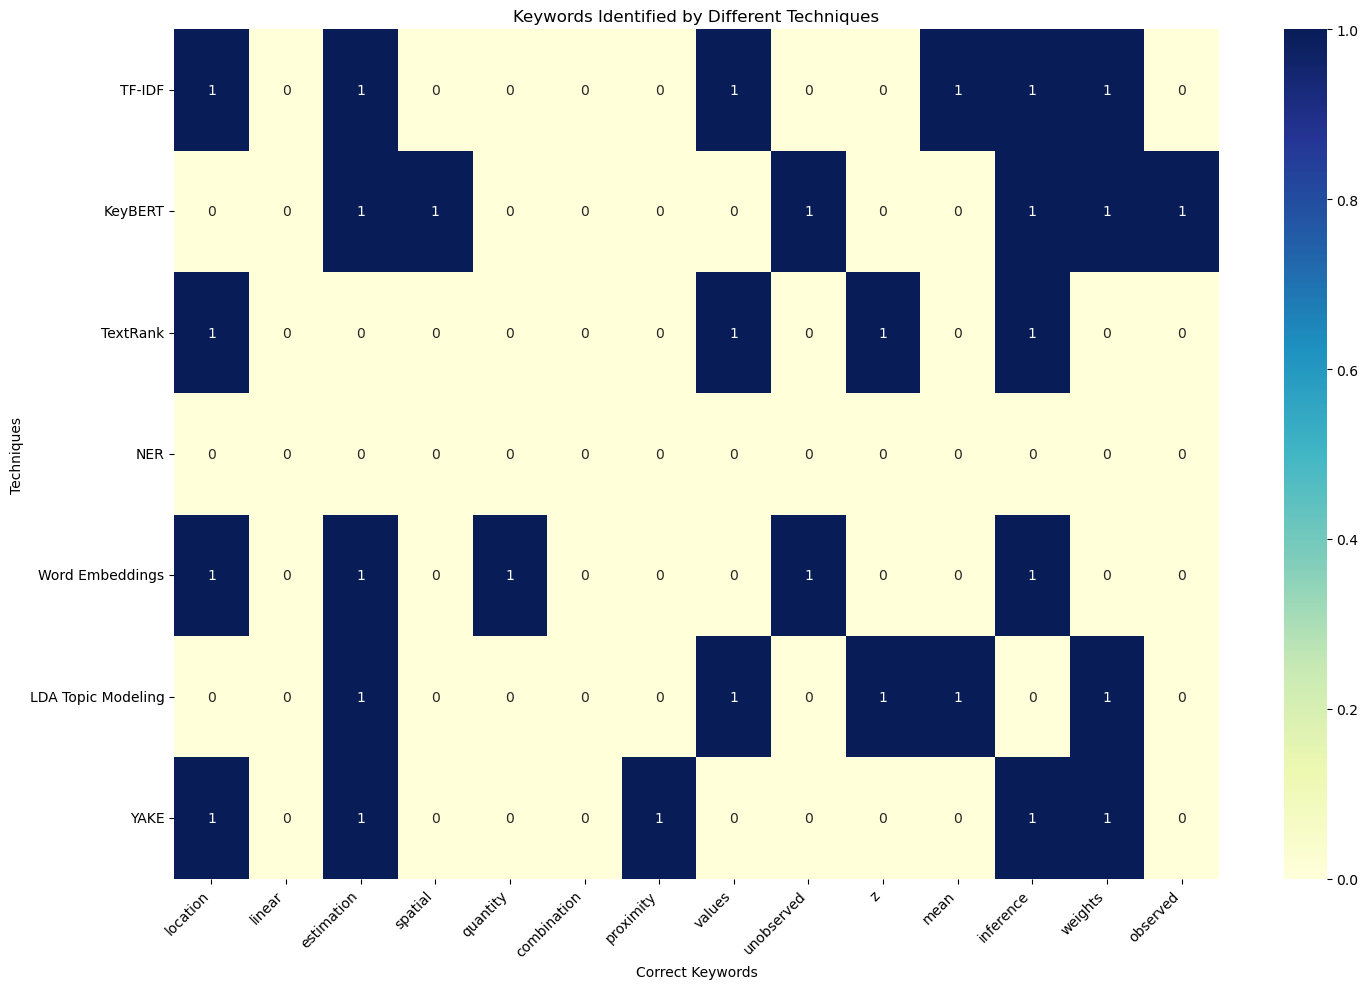

In [31]:
# Main execution
if __name__ == "__main__":
    # Input text to analyze
    text = text_test
    
    # List of correct keywords for evaluation
    eval_list = prime_keywords
    
    # Apply different keyword extraction techniques
    technique_results = {
        'TF-IDF': tf_idf(text),
        'KeyBERT': keybert_extraction(text),
        'TextRank': textrank(text),
        'NER': named_entity_recognition(text),
        'Word Embeddings': word_embeddings(text),
        'LDA Topic Modeling': lda_topic_modeling(text),
        'YAKE': yake_extraction(text)
    }
    
    # Evaluate the performance of each technique
    evaluation = evaluate_techniques(eval_list, technique_results)
    
    # Print evaluation results
    print("Eval List:")
    print(eval_list)
    print("Results:")
    for technique, results in technique_results.items():
        print(f"\n{technique}:")
        print(f"Extracted keywords: {results}")
        print(f"Correct found: {evaluation[technique]['correct_found']}")
        print(f"Incorrect found: {evaluation[technique]['incorrect_found']}")
    
    # Visualize the results
    visualize_results(eval_list, technique_results)


### Summary Test: Evaluation

In [23]:
# Main execution
if __name__ == "__main__":
    # Input text to analyze
    text = text_test
    
    # List of correct keywords for evaluation
    correct_list = summary_keywords
    
    # Apply different keyword extraction techniques
    technique_results = {
        'TF-IDF': tf_idf(text),
        'KeyBERT': keybert_extraction(text),
        'TextRank': textrank(text),
        'NER': named_entity_recognition(text),
        'Word Embeddings': word_embeddings(text),
        'LDA Topic Modeling': lda_topic_modeling(text),
        'YAKE': yake_extraction(text)
    }
    
    # Evaluate the performance of each technique
    evaluation = evaluate_techniques(correct_list, technique_results)
    
    # Print evaluation results
    print("Correct List:")
    print(correct_list)
    print("Results:")
    for technique, results in technique_results.items():
        print(f"\n{technique}:")
        print(f"Extracted keywords: {results}")
        print(f"Correct found: {evaluation[technique]['correct_found']}")
        print(f"Incorrect found: {evaluation[technique]['incorrect_found']}")

Correct List:
['linear', 'estimation', 'spatial', 'deviations', 'unbiased', 'quantity', 'combination', 'global', 'using', 'unbias', 'equal', 'squared', 'location', 'proximity', 'z', 'weights', 'involves', 'real', 'estimations', 'values', 'unobserved', 'estimating', 'x0', 'inference', 'mean', 'minimal', 'observed']
Results:

TF-IDF:
Extracted keywords: ['displaystyle', 'values', 'x_', 'cloud', 'estimation', 'mean', 'real', 'w_', 'weights', 'estimated', 'inference', 'location', 'minimal', 'stationarity']
Correct found: 8
Incorrect found: 6

KeyBERT:
Extracted keywords: ['desegregation', 'estimation', 'estimations', 'unobserved', 'unbias', 'inference', 'weights', 'bias', 'observed', 'estimator', 'spatial', 'intrinsic', 'samples', 'geostatistical']
Correct found: 8
Incorrect found: 6

TextRank:
Extracted keywords: ['z', 'z_', 'displaystyle', 'values', 'unbias', 'stationarity', 'criterion', 'important', 'samples', 'sample', 'bias', 'r', 'x_', 'process', 'inference', 'location', 'x']
Correct

### Rewrite test: Evaluation

In [25]:
# Main execution
if __name__ == "__main__":
    text = text_test

    correct_list = rewrite_keywords

    technique_results = {
        'TF-IDF': tf_idf(text),
        'KeyBERT': keybert_extraction(text),
        'TextRank': textrank(text),
        'NER': named_entity_recognition(text),
        'Word Embeddings': word_embeddings(text),
        'LDA Topic Modeling': lda_topic_modeling(text),
        'YAKE': yake_extraction(text)
    }

    evaluation = evaluate_techniques(correct_list, technique_results)
    print("Rewrite List:")
    print(correct_list)
    print("Results:")
    for technique, results in technique_results.items():
        print(f"\n{technique}:")
        print(f"Extracted keywords: {results}")
        print(f"Correct found: {evaluation[technique]['correct_found']}")
        print(f"Incorrect found: {evaluation[technique]['incorrect_found']}")

Correct List:
['estimation', 'spatial', 'also', 'deviations', 'geostatistical', 'ensuring', 'unbiased', 'variance', 'quantity', 'global', 'realm', 'samples', 'process', 'location', 'proximity', 'z', 'weights', 'involves', 'real', 'values', 'estimator', 'minimal', 'observed']
Results:

TF-IDF:
Extracted keywords: ['displaystyle', 'values', 'x_', 'cloud', 'estimation', 'mean', 'real', 'w_', 'weights', 'estimated', 'inference', 'location', 'minimal', 'stationarity']
Correct found: 6
Incorrect found: 8

KeyBERT:
Extracted keywords: ['desegregation', 'estimation', 'estimations', 'unobserved', 'unbias', 'inference', 'weights', 'bias', 'observed', 'estimator', 'spatial', 'intrinsic', 'samples', 'geostatistical']
Correct found: 7
Incorrect found: 7

TextRank:
Extracted keywords: ['z', 'z_', 'displaystyle', 'values', 'unbias', 'stationarity', 'criterion', 'important', 'samples', 'sample', 'bias', 'r', 'x_', 'process', 'inference', 'location', 'x']
Correct found: 5
Incorrect found: 12

NER:
Extr